In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from PerturbSeq_CMV.paths import DATA_DIR

In [2]:
folder = DATA_DIR / "rawdata" / "CRISPRn_perturb_virus_host_processed"

In [3]:
adata_genesxcells = sc.read_mtx(folder / "matrix.mtx")

Transpose

In [4]:
adata = anndata.AnnData(adata_genesxcells.X.T)
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

**Read metadata**

In [5]:
barcode_path = folder / "barcodes.tsv"
cellidentity_path = folder / "cell_identities.csv"
genes_path = folder /"genes.tsv"

In [6]:
barcodes = pd.read_csv(barcode_path, sep="\t", header=None)
cellidentity = pd.read_csv(cellidentity_path)
genes = pd.read_csv(genes_path, sep="\t", header=None)
genes.columns = ["ENSMBL", "gene ID"]

In [7]:
metadata = pd.read_excel(folder / "CRISPRn_perturb_virus_host_processed.xlsx")
metadata.head()

,cell_barcode,gem_group,UMI_count,guide_UMI_count,guide_read_count,guide_coverage,experimental_time,guide_identity,guide_target,guide_target_organism,guide_phenotype,guide_rank,cell_cycle_phase,viral_load,interferon_score,cluster,UMAP_1,UMAP_2
0,AAACCTGAGAGGTTAT-1,1,13647,89,1818,20.426966,00h,human_IFNAR2_pMH2500,IFNAR2,human,sensitizing,2,G2-M,0.000000,-0.163565,naive,-6.089045,0.183853
1,AAACCTGAGGCGCTCT-1,1,14248,49,969,19.775510,00h,human_BCL2L1_pMH2490,BCL2L1,human,sensitizing,1,S,0.000000,1.386511,infected_1,1.837967,-5.857284
2,AAACCTGAGTCGTACT-1,1,9692,20,295,14.750000,00h,HCMV_UL70_pMH2340,UL70,HCMV,protective,2,M-G1,0.000000,-0.392279,naive,-8.474256,-1.731229
3,AAACCTGAGTGCAAGC-1,1,16595,60,1066,17.766667,00h,HCMV_UL141_pMH2384,UL141,HCMV,protective,2,S,0.000000,-0.209550,naive,-5.834652,-0.998549
4,AAACCTGAGTTCGCGC-1,1,6127,7,160,22.857143,00h,human_IFNAR2_pMH2498,IFNAR2,human,sensitizing,1,G2-M,0.000163,-1.168588,naive,-5.862441,0.085474


Information is both for viral and human reads 

Keep only a fraction of cells 

In [8]:
cells_to_keep = barcodes.loc[barcodes.isin(np.array(metadata.cell_barcode))[0]]
# Get indexes
cells_to_keep_idx = np.array(cells_to_keep.index)

In [9]:
adata = adata[cells_to_keep_idx,:]

In [10]:
adata.obs = metadata

Turn time into float 

In [11]:
metadata.experimental_time = [float(time.split('h')[0]) for time in metadata.experimental_time]

Set metadata df as obs

In [12]:
adata.var = pd.DataFrame(genes)
adata.var.index = adata.var["gene ID"]
adata.var["mt"] = adata.var_names.str.startswith("MT-") 

**Examine metadata**

In [13]:
print(f"Number of targets {len(np.unique(metadata.guide_target))}")

Number of targets 54


In [14]:
np.unique(np.unique(metadata.guide_target))

array(['ASNA1', 'B4GALT7', 'BCL2L1', 'CASP9', 'COG8', 'CSNK2A1', 'CYCS',
       'DDA1', 'EXT2', 'FLCN', 'HS6ST1', 'IFNAR2', 'KIAA1432', 'LAMTOR2',
       'LAMTOR3', 'ORFL150C', 'ORFL151C', 'ORFL152C', 'ORFL253W_(UL112)',
       'ORFL257C', 'PDGFRA', 'RGP1', 'SEC62', 'SLC35B2', 'STAT2', 'UL102',
       'UL105', 'UL115', 'UL119', 'UL121', 'UL122', 'UL123', 'UL135',
       'UL141', 'UL144', 'UL148', 'UL35', 'UL36', 'UL37', 'UL38', 'UL40',
       'UL42', 'UL43', 'UL52', 'UL53', 'UL54', 'UL55', 'UL56', 'UL57',
       'UL69', 'UL70', 'UNC50', 'control-HCMV', 'control-human'],
      dtype=object)

21 factors human, 31 factors virus plus 1 control each

In [15]:
np.unique(metadata.guide_phenotype)

array(['control', 'protective', 'sensitizing'], dtype=object)

Pre-process

In [16]:
highly_expressed_genes = np.array((adata.X.todense().sum(0)>10000).astype(np.bool)).squeeze(0)
print(f"Number of genes with more than 10k counts: {np.sum(highly_expressed_genes)}")
adata.var["highly_variable"] = highly_expressed_genes
sc.pp.normalize_total(adata, np.mean(adata.X.sum(1)))

Number of genes with more than 10k counts: 5172


PCA and UMAP

In [17]:
# PCA
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [18]:
sc.pp.neighbors(adata, n_pcs=40)

In [19]:
sc.tl.umap(adata,  min_dist=0.1, spread=1.5)

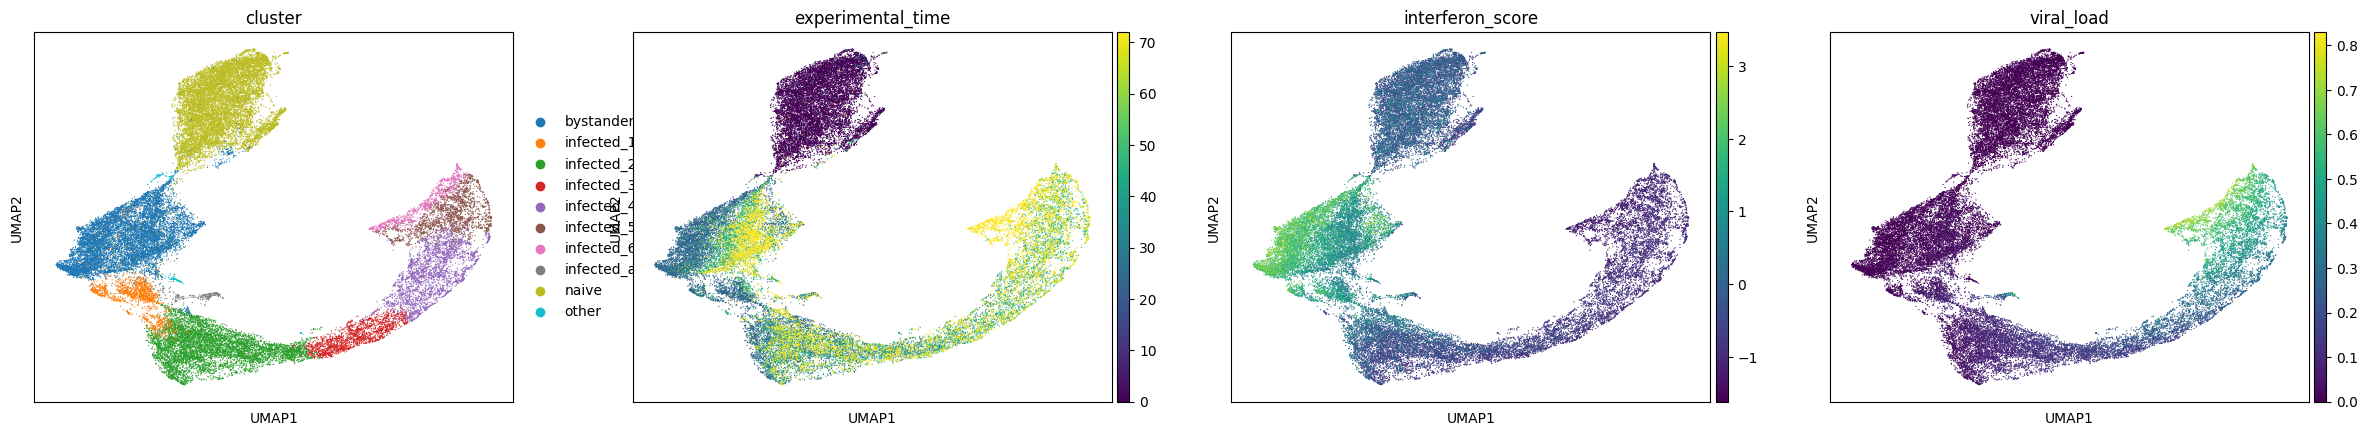

In [20]:
sc.pl.umap(adata, color=["cluster", "experimental_time", "interferon_score", "viral_load"])

**Save the anndata**

In [21]:
processed_data_dir = DATA_DIR / "processed"

In [22]:
adata.write(processed_data_dir / "perturb_seq_host_viral_factors.h5ad")